<div class="alert alert-success" role="alert">
  <h5>Our Libraries</h5>
</div>


In [400]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [401]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

# For RNN model
from keras.models import Sequential
from tensorflow.keras import layers

# Optimizers
from tensorflow.keras.optimizers import Adam, RMSprop, Adadelta, SGD



%matplotlib inline
plt.rcParams.update({'font.size': 20})



<div class="alert alert-success" role="alert">
  <h5>Our Constants</h5>
</div>


In [402]:
START = "2017-12-29"
END = "2022-12-15"
PAST_N_DAYS = 90
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 1

<div class="alert alert-success" role="alert">
  <h5>Our Functions</h5>
</div>


In [403]:
def Target_to_date_x_y(df):
    df_as_np = df.to_numpy()

    dates = df_as_np[:, 0]

    middle_matrix = df_as_np[:, 1:-1]
    X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

    Y = df_as_np[:, -1]

    return dates, X.astype(np.float32), Y.astype(np.float32)

In [404]:
def N_Target(df, first_date_str, last_date_str, n=3):
    
    first_date = pd.to_datetime(first_date_str)
    last_date  = pd.to_datetime(last_date_str)

    target_date = first_date

    dates = []
    X, Y = [], []

    last_time = False
    
    while True:
        df_subset = df.loc[:target_date].tail(n+1)

        if len(df_subset) != n+1:
            print(f'Error: Window of size {n} is too large for date {target_date}')
            return

        values = df_subset['Close'].to_numpy()
        x, y = values[:-1], values[-1]

        dates.append(target_date)
        X.append(x)
        Y.append(y)

        next_week = df.loc[target_date:target_date+datetime.timedelta(days=7)]
        next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
        next_date_str = next_datetime_str.split('T')[0]
        year_month_day = next_date_str.split('-')
        year, month, day = year_month_day
        next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

        if last_time:
            break

        target_date = next_date

        if target_date == last_date:
            last_time = True
    
    ret_df = pd.DataFrame({})
    ret_df['Target Date'] = dates
  
    X = np.array(X)
    for i in range(0, n):
        X[:, i]
        ret_df[f'Target-{n-i}'] = X[:, i]
  
    ret_df['Target'] = Y

    return ret_df

In [405]:
def check_stationarity(df):
    df = df.dropna()
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df, autolag='AIC')

    if result[0] < result[4].get("1%"):
        print("Passes on the 1% Critial Value")
        
    elif result[0] < result[4].get("5%"):
        print("Passes on the 5% Critial Value")
    
    elif result[0] < result[4].get("10%"):
        print("Passes on the 10% Critial Value")
    
    else:
        print("Failed")


In [406]:
def do_stationarity(df):
    """ 
    This function takes a Non-stationarity DataFrame
    Returns a stationarity one by applying following equation
        df = df - df.shift(1)
    """
    df = df - df.shift(1)
    
    # Dropping the nulls, which is only the frist row in the dataframe
    df = df.dropna()
    
    return df

In [407]:
def inv_stationarity(df_original, df_stationarity):
    df_original = df_original.dropna()

    """ 
    Inverse stationarity function takes a the original & Stationarity DataFrame
    Returns a Stationarity originally form
    """
    dfr = (df_stationarity.cumsum()*df_stationarity.iloc[-1])

    from sklearn import preprocessing

    scaler = preprocessing.MinMaxScaler(feature_range=(df_original.min()[0], df_original.max()[0]))

    names = dfr.columns
    d = scaler.fit_transform(dfr)
    dfr = pd.DataFrame(d, columns=names)
    return dfr

In [408]:
def plotdf(df , mean = True):
    df = df.dropna()
    import matplotlib.pyplot as plt
    plt.rcParams["figure.figsize"] = (25,8)
    plt.title("CIB stock market price for Five years")
    plt.ylabel("Price in USD")
    plt.xlabel("Time in Years")
    plt.plot(df.index, df['Close']);
    if mean:
        plt.axhline(df['Close'].mean());

In [409]:
def ADF_details(df):
    df = df.dropna()
    from statsmodels.tsa.stattools import adfuller
    result = adfuller(df, autolag='AIC')
    print(f'ADF Statistic: {result[0]}\n')
    print(f'p-value: {result[1]}\n')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')

In [410]:
def recursive_prediction(model,y,PAST_N_DAYS,dates_recursive, print_detail = False):
    '''
    predict lenght consecutive values from a real one
    '''

    x_input=y[len(y)-PAST_N_DAYS-1:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()

    y_recursive=[]
    i=0

    while(i<len(dates_recursive)):

        if(len(temp_input)>PAST_N_DAYS):
            x_input=np.array(temp_input[1:])
            if print_detail:
                print("{} day input {}".format(i,x_input))
            x_input=x_input.reshape(1,-1)
            x_input = x_input.reshape((1, PAST_N_DAYS, 1))
            yhat = model.predict(x_input, verbose=0)
            if print_detail:
                print("{} day output {}\n".format(i,yhat))
            temp_input.extend(yhat[0].tolist())
            temp_input=temp_input[1:]
            y_recursive.extend(yhat.tolist())
            i=i+1
        else:
            x_input = x_input.reshape((1, PAST_N_DAYS,1))
            yhat = model.predict(x_input, verbose=0)
            if print_detail:
                print(yhat[0])
            temp_input.extend(yhat[0].tolist())
            if print_detail:
                print(len(temp_input))
            y_recursive.extend(yhat.tolist())
            i=i+1

    return scaler.inverse_transform(y_recursive);

<div class="alert alert-success" role="alert">
  <h5>Pulling CIB stock market prices form yahoo finance API</h5>
</div>


In [411]:
# Pulling the data form yahoo finance
import yfinance as yf

# Commercial International Bank in Egypt
df = yf.download('CIBEY', start = START, end = END)

[*********************100%***********************]  1 of 1 completed


<div class="alert alert-success" role="alert">
  <h5>Let's talk about the stock market</h5>
</div>


![OHLC Chart](https://datavizcatalogue.com/methods/images/anatomy/SVG/OHLC_chart.svg)

In [412]:
from plotly.offline import iplot
import plotly.graph_objs as go

trace = go.Ohlc(x=df.index,
                open=df.Open['1-2018'],
                high=df.High['1-2018'],
                low=df.Low['1-2018'],
                close=df.Close['1-2018'])

trace_all = go.Ohlc(x=df.index,
                open=df.Open,
                high=df.High,
                low=df.Low,
                close=df.Close)
# iplot([trace_all])
iplot([trace])

In [413]:
df = df.filter(['Close'])

df = df.asfreq('b')

df = df.fillna(method="bfill")

In [414]:
df.tail()

,Close
Date,
2022-12-08,1.25
2022-12-09,1.24
2022-12-12,1.29
2022-12-13,1.24
2022-12-14,1.28


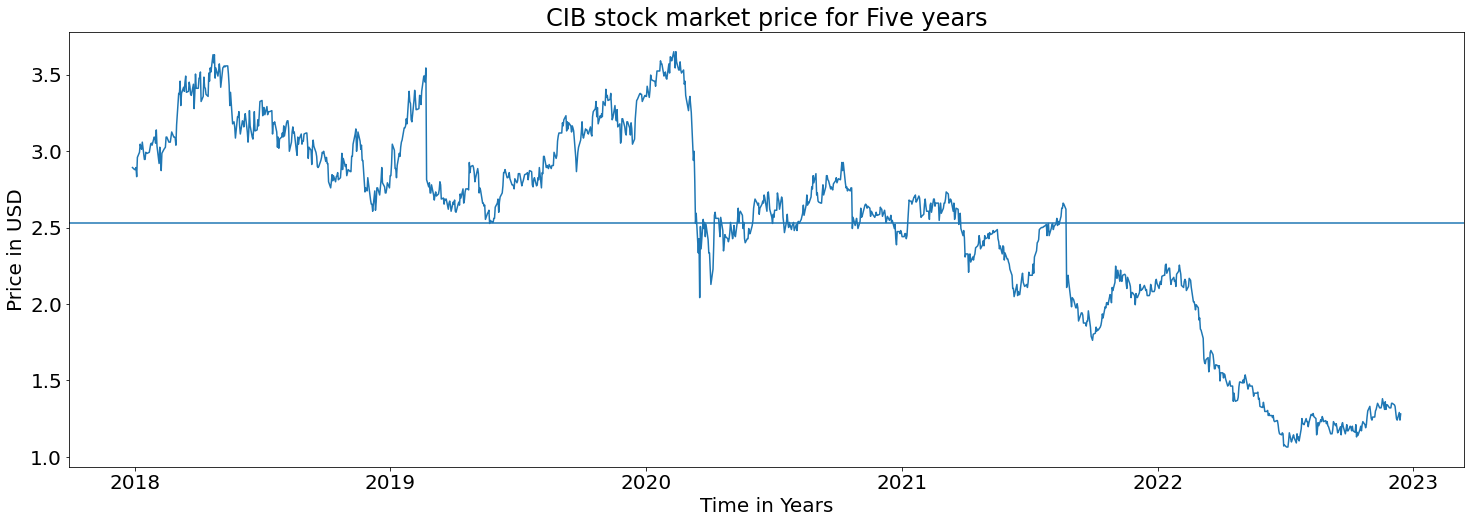

In [415]:
plotdf(df)

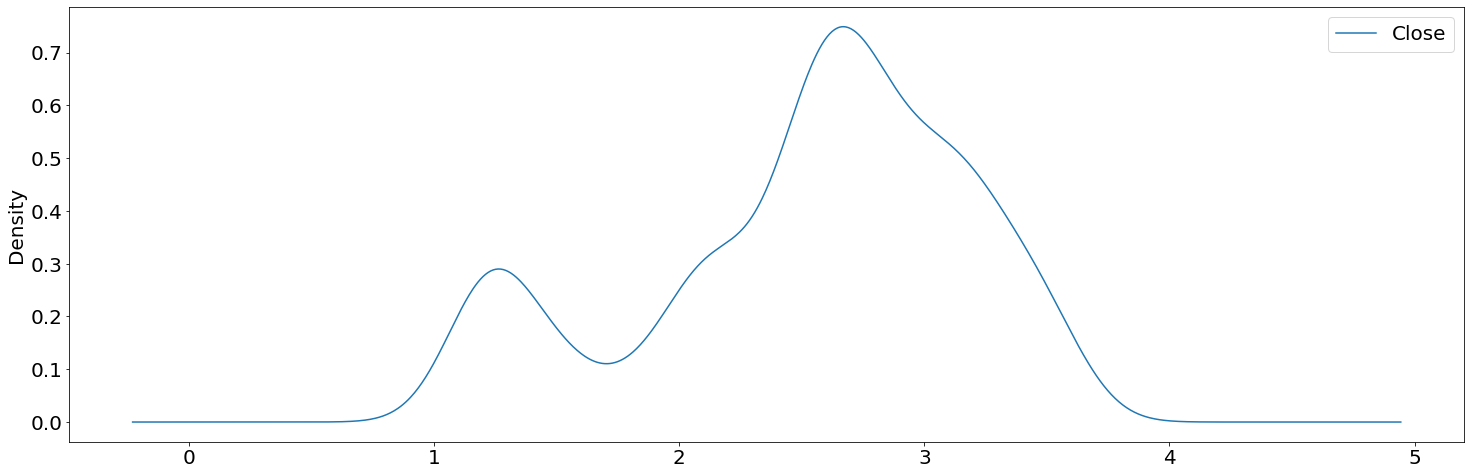

In [416]:
df.plot(kind='kde');

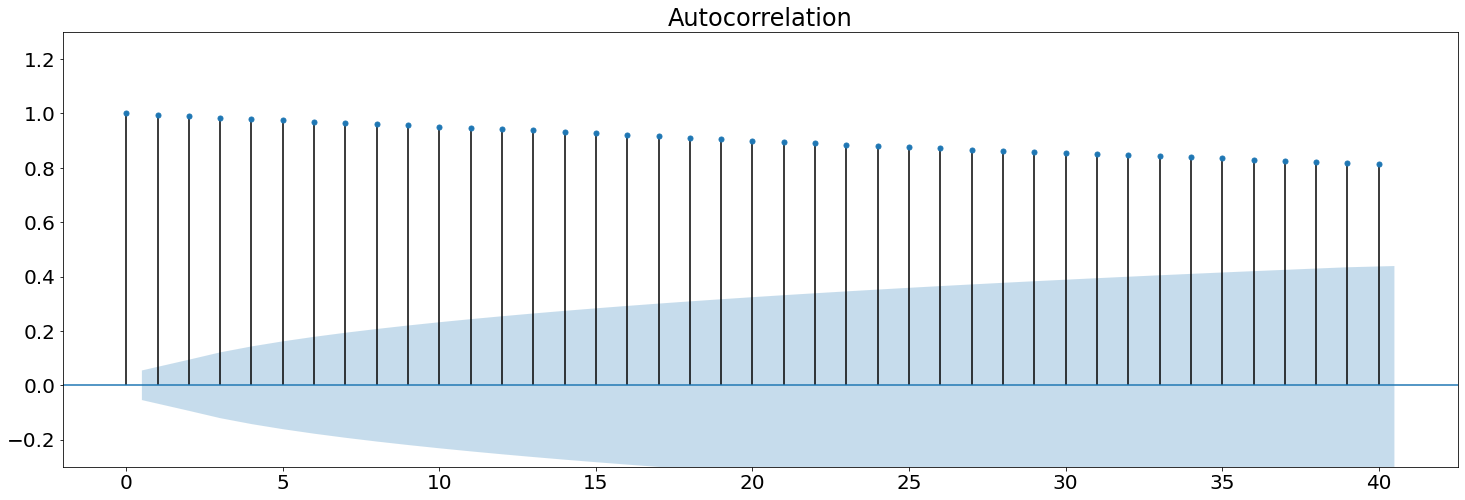

In [417]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
plot_acf(df,lags=40)
plt.ylim(-0.3,1.3);

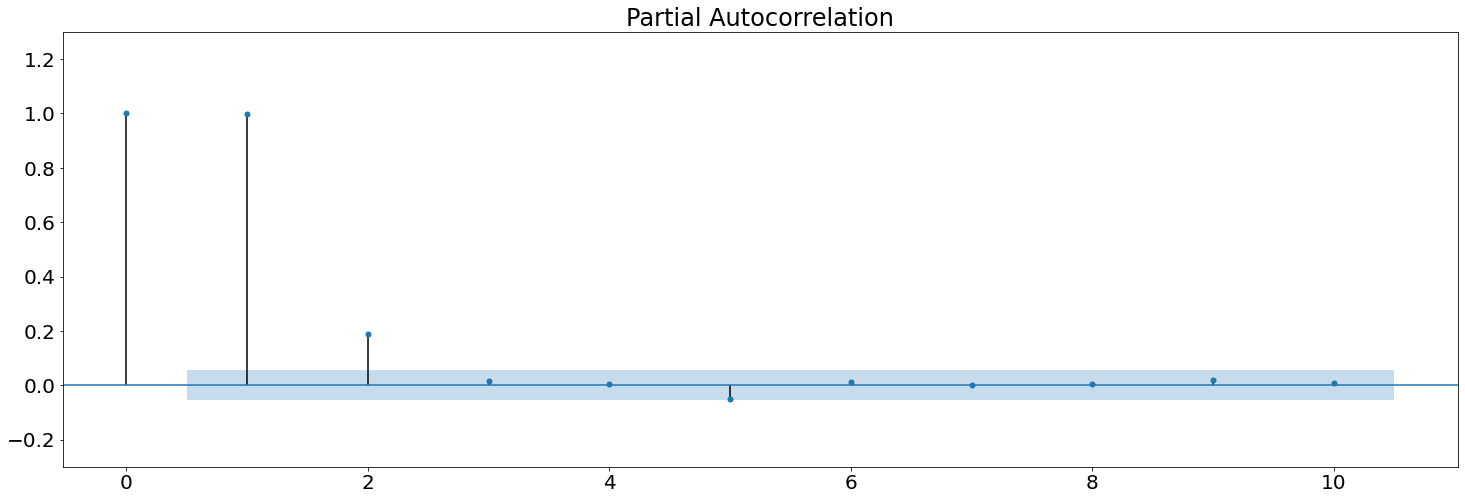

In [418]:
plot_pacf(df,lags=10, method='ols')
plt.ylim(-0.3,1.3);

# MinMaxScaler

In [419]:
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))

df = scaler.fit_transform(df)
df = pd.DataFrame(data = df, columns = ["Close"])

In [420]:
time = pd.date_range(start='2017-12-29',end='2022-12-14',freq='B')
df.index = time

In [421]:
Target_df = N_Target(df, 
                       '2018-06-01',
                       '2022-12-14',
                       n = PAST_N_DAYS)
Target_df

,Target Date,Target-90,Target-89,Target-88,Target-87,Target-86,Target-85,Target-84,Target-83,Target-82,...,Target-9,Target-8,Target-7,Target-6,Target-5,Target-4,Target-3,Target-2,Target-1,Target
0,2018-06-01,0.763496,0.784062,0.781491,0.768638,0.802057,0.760925,0.717224,0.758355,0.724936,...,0.817481,0.820051,0.822622,0.809769,0.781491,0.835476,0.835476,0.848329,0.812340,0.791774
1,2018-06-04,0.784062,0.781491,0.768638,0.802057,0.760925,0.717224,0.758355,0.724936,0.699229,...,0.820051,0.822622,0.809769,0.781491,0.835476,0.835476,0.848329,0.812340,0.791774,0.825193
2,2018-06-05,0.781491,0.768638,0.802057,0.760925,0.717224,0.758355,0.724936,0.699229,0.742930,...,0.822622,0.809769,0.781491,0.835476,0.835476,0.848329,0.812340,0.791774,0.825193,0.822622
3,2018-06-06,0.768638,0.802057,0.760925,0.717224,0.758355,0.724936,0.699229,0.742930,0.753213,...,0.809769,0.781491,0.835476,0.835476,0.848329,0.812340,0.791774,0.825193,0.822622,0.809769
4,2018-06-07,0.802057,0.760925,0.717224,0.758355,0.724936,0.699229,0.742930,0.753213,0.755784,...,0.781491,0.835476,0.835476,0.848329,0.812340,0.791774,0.825193,0.822622,0.809769,0.830334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179,2022-12-08,0.051414,0.061696,0.082262,0.082262,0.079692,0.084833,0.077121,0.071979,0.030848,...,0.106776,0.099044,0.099044,0.099044,0.110643,0.110643,0.106776,0.102910,0.087445,0.071979
1180,2022-12-09,0.061696,0.082262,0.082262,0.079692,0.084833,0.077121,0.071979,0.030848,0.041131,...,0.099044,0.099044,0.099044,0.110643,0.110643,0.106776,0.102910,0.087445,0.071979,0.068113
1181,2022-12-12,0.082262,0.082262,0.079692,0.084833,0.077121,0.071979,0.030848,0.041131,0.061696,...,0.099044,0.099044,0.110643,0.110643,0.106776,0.102910,0.087445,0.071979,0.068113,0.087445
1182,2022-12-13,0.082262,0.079692,0.084833,0.077121,0.071979,0.030848,0.041131,0.061696,0.053984,...,0.099044,0.110643,0.110643,0.106776,0.102910,0.087445,0.071979,0.068113,0.087445,0.068113


# REShaping

In [422]:
dates, x, y = Target_to_date_x_y(Target_df)
y = y.reshape(-1, 1)
dates.shape, x.shape, y.shape

((1184,), (1184, 90, 1), (1184, 1))

In [423]:
_80 = int(len(dates) * .8)
_90 = int(len(dates) * .9)

# Dates of the Train data & x_train & y_train => 80%
#(jan - 2018) upto (jan - 2022)
dates_train, x_train, y_train = dates[:_80], x[:_80], y[:_80]

#=============================================================

# Dates of the Validation & x_val & y_val => 10%
#(jan - 2022) upto (june - 2022)
dates_val, x_val, y_val = dates[_80:_90], x[_80:_90], y[_80:_90]


#=============================================================


# Dates of the Testing & x_Test & y_test => 10%
#(june - 2022) upto (dec - 2022)
dates_test, x_test, y_test = dates[_90:], x[_90:], y[_90:]


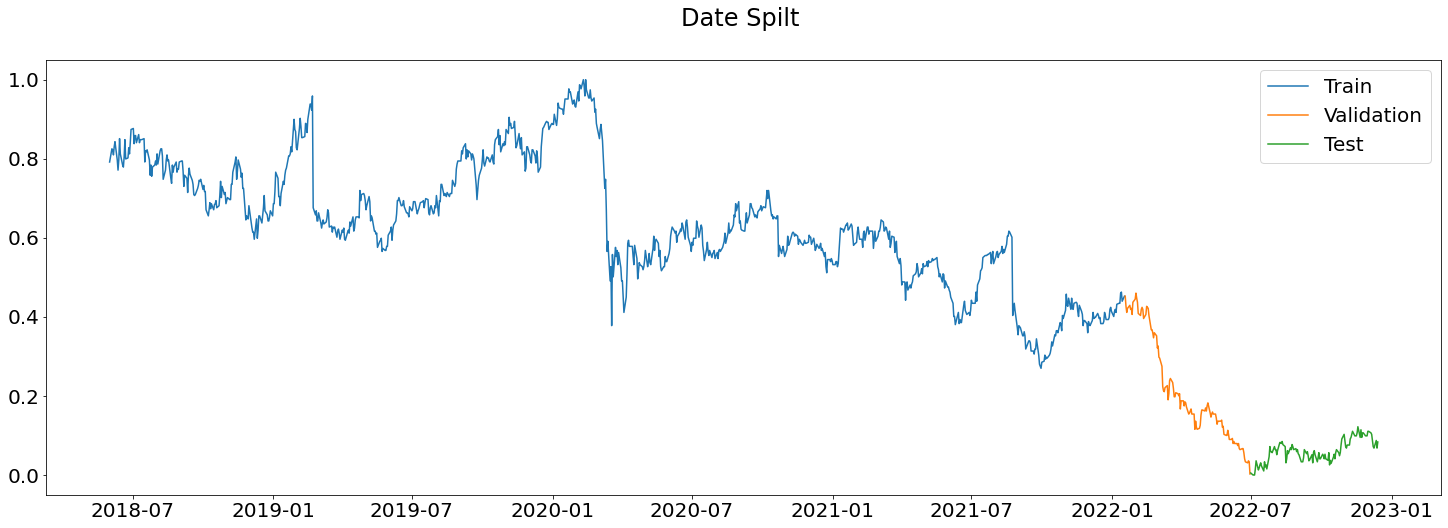

In [424]:
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Date Spilt \n")
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)
plt.legend(['Train', 'Validation', 'Test']);

In [425]:
df_train=pd.DataFrame(y_train, columns=['Close'])
df_train.index = dates_train

<div class="alert alert-success" role="alert">
  <h3 class="alert-heading">Let's Talk About STATIONARITY!</h3>
  <hr>
  <p class="mb-0"><p>The word "Stationarity" means</p>
    <br> &ensp; &ensp; &#9673  &ensp;  Our $\mu$ is constant.
    <br> &ensp; &ensp; &#9673  &ensp;  Our $\sigma$ is constant
    <br> &ensp; &ensp; &#9673  &ensp;  We have NO Seasonality
    </p>
</div>

In [426]:
check_stationarity(df_train)

Failed


In [427]:
ADF_details(df_train)

ADF Statistic: -2.1602985908080714

p-value: 0.22096888332201514

Critial Values:
   1%, -3.4372887850912175
   5%, -2.8646033071530703
   10%, -2.568401081996585


<div class="alert alert-warning" role="alert">
    ADF Statistic < None of the critical values
    <br>                    
     Thus, We don't have Stationarity
</div>

In [428]:
df_train_stationarity = do_stationarity(df_train)

In [429]:
df_train_stationarity.describe()

,Close
count,946.000000
mean,-0.000359
std,0.026345
min,-0.282776
25%,-0.012854
50%,0.000000
75%,0.012854
max,0.179949


In [430]:
check_stationarity(df_train_stationarity)

Passes on the 1% Critial Value


In [431]:
df_train_stationarity

,Close
2018-06-04,0.033419
2018-06-05,-0.002571
2018-06-06,-0.012853
2018-06-07,0.020565
2018-06-08,0.012854
...,...
2022-01-11,0.000000
2022-01-12,0.025707
2022-01-13,0.002571
2022-01-14,-0.023136


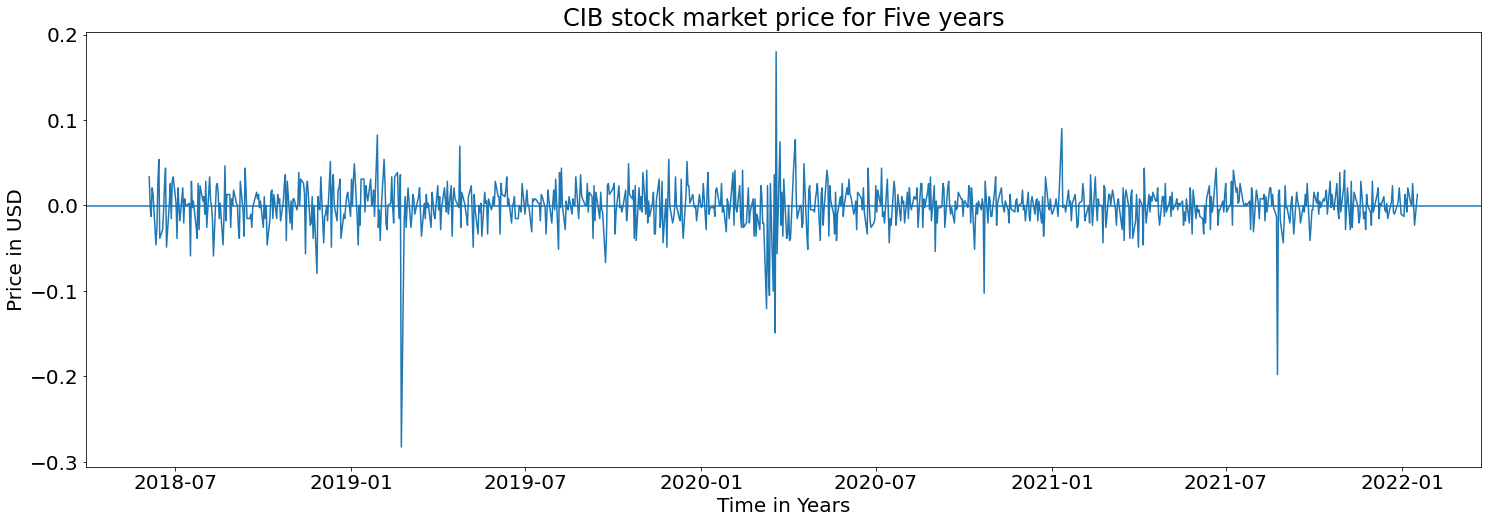

In [432]:
plotdf(df_train_stationarity)

In [433]:
Target_df_train = N_Target(df_train_stationarity, 
                       '2018-01-18',
                       '2018-07-11',
                       n = PAST_N_DAYS)
Target_df_train

# dates_train, x_train, y_train = Target_to_date_x_y(Target_df_train)

Error: Window of size 90 is too large for date 2018-01-18 00:00:00


# <div class="alert alert-success" role="alert">
  <h1>Welcome to the RNN Model</h1>  <hr>
</div>

# **What** **are** **Recurrent** **Neural** **Networks** ? 

![HOW]( https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/unrolled-rnn_0.png)



# **RNN** **Model** 

In [434]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout

#Initialize RNN:
model = Sequential()

#Adding the first RNN layer and some Dropout regularization
model.add(SimpleRNN(units = 32, activation='tanh', return_sequences=True, input_shape = (PAST_N_DAYS,1)))

#Adding the second RNN layer and some Dropout regularization
model.add(SimpleRNN(units = 32, activation='tanh', return_sequences=True))

#Adding the third RNN layer and some Dropout regularization
model.add(SimpleRNN(units = 32, activation='tanh', return_sequences=True))

#Adding the fourth RNN layer and some Dropout regularization
model.add(SimpleRNN(units = 32))

#Adding the output layer
model.add(Dense(units = 1))

#Compile the RNN
model.compile(loss='mae', #L1
              optimizer=Adam(learning_rate = LEARNING_RATE),
              metrics=['mean_squared_error'])

#Fitting the RNN to the Training set
model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 10, epochs = 20, verbose = 1);

Epoch 1/20
95/95 [==============================] - 10s 73ms/step - loss: 0.0726 - mean_squared_error: 0.0170 - val_loss: 0.0511 - val_mean_squared_error: 0.0033
Epoch 2/20
95/95 [==============================] - 6s 67ms/step - loss: 0.0445 - mean_squared_error: 0.0033 - val_loss: 0.0341 - val_mean_squared_error: 0.0025
Epoch 3/20
95/95 [==============================] - 6s 67ms/step - loss: 0.0284 - mean_squared_error: 0.0015 - val_loss: 0.0380 - val_mean_squared_error: 0.0024
Epoch 4/20
95/95 [==============================] - 6s 66ms/step - loss: 0.0388 - mean_squared_error: 0.0026 - val_loss: 0.0499 - val_mean_squared_error: 0.0067
Epoch 5/20
95/95 [==============================] - 6s 67ms/step - loss: 0.0283 - mean_squared_error: 0.0014 - val_loss: 0.0554 - val_mean_squared_error: 0.0088
Epoch 6/20
95/95 [==============================] - 6s 67ms/step - loss: 0.0306 - mean_squared_error: 0.0016 - val_loss: 0.0510 - val_mean_squared_error: 0.0065
Epoch 7/20
95/95 [===============

In [435]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_58 (SimpleRNN)   (None, 90, 32)            1088      
                                                                 
 simple_rnn_59 (SimpleRNN)   (None, 90, 32)            2080      
                                                                 
 simple_rnn_60 (SimpleRNN)   (None, 90, 32)            2080      
                                                                 
 simple_rnn_61 (SimpleRNN)   (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [436]:
x_train

array([[[0.76349616],
        [0.78406155],
        [0.7814908 ],
        ...,
        [0.83547556],
        [0.8483291 ],
        [0.8123395 ]],

       [[0.78406155],
        [0.7814908 ],
        [0.76863766],
        ...,
        [0.8483291 ],
        [0.8123395 ],
        [0.7917737 ]],

       [[0.7814908 ],
        [0.76863766],
        [0.8020566 ],
        ...,
        [0.8123395 ],
        [0.7917737 ],
        [0.8251927 ]],

       ...,

       [[0.352185  ],
        [0.31876606],
        [0.33418995],
        ...,
        [0.43444726],
        [0.43444726],
        [0.46015406]],

       [[0.31876606],
        [0.33418995],
        [0.33933142],
        ...,
        [0.43444726],
        [0.46015406],
        [0.46272478]],

       [[0.33418995],
        [0.33933142],
        [0.33933142],
        ...,
        [0.46015406],
        [0.46272478],
        [0.4395887 ]]], dtype=float32)

30/30 [==============================] - 1s 19ms/step


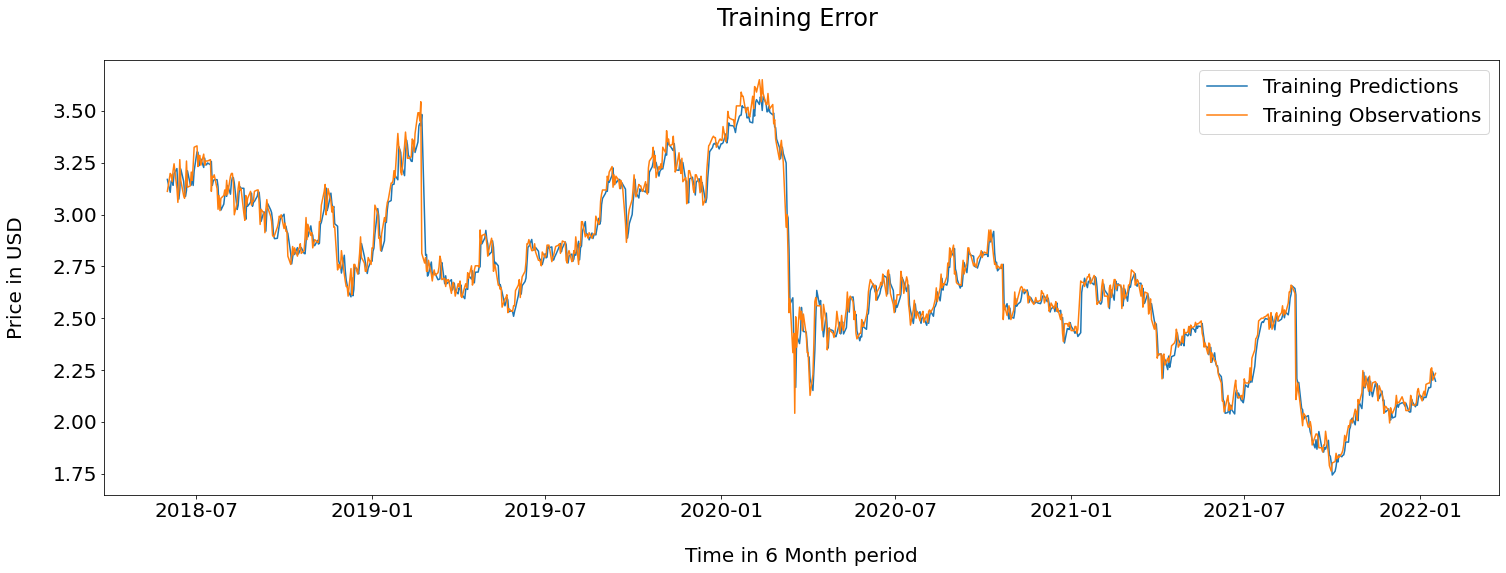

In [437]:
train_predictions = model.predict(x_train)

train_predictions=scaler.inverse_transform(train_predictions)
y_train=scaler.inverse_transform(y_train)

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.title("Training Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in 6 Month period")
plt.rcParams["figure.figsize"] = (25,8)
plt.legend(['Training Predictions', 'Training Observations']);

4/4 [==============================] - 0s 19ms/step


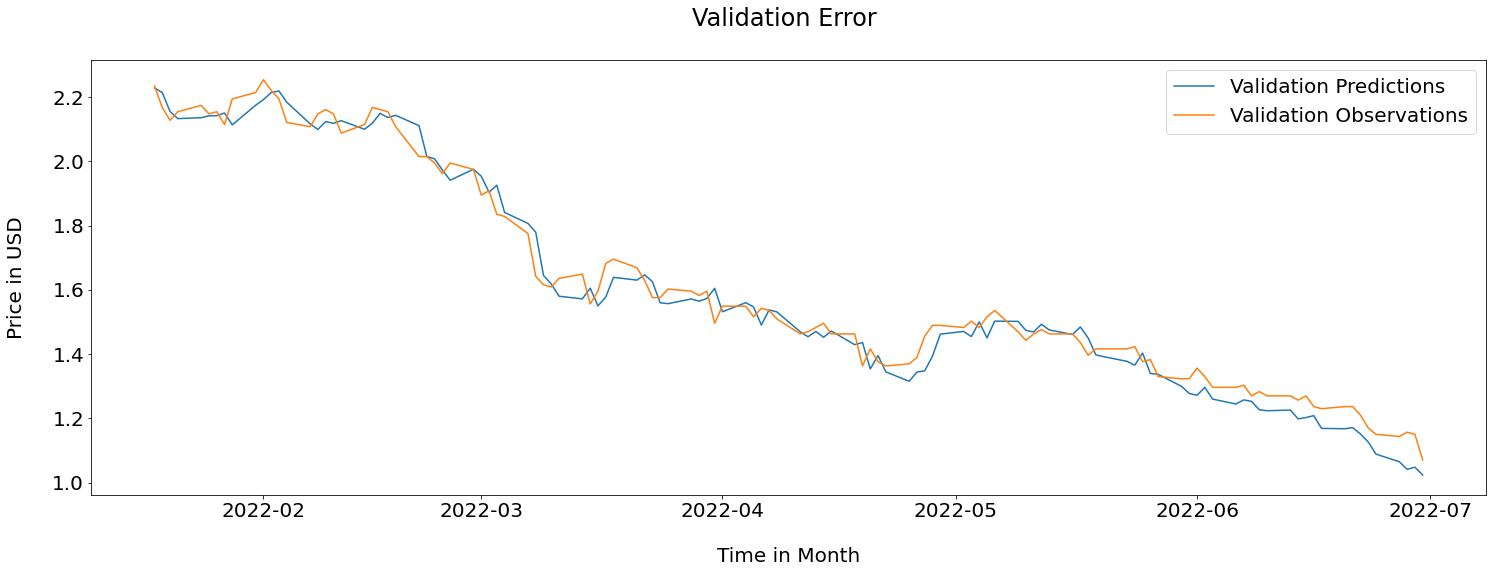

In [438]:
val_predictions = model.predict(x_val)

val_predictions=scaler.inverse_transform(val_predictions)
y_val=scaler.inverse_transform(y_val)

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Validation Predictions', 'Validation Observations']);

4/4 [==============================] - 0s 19ms/step


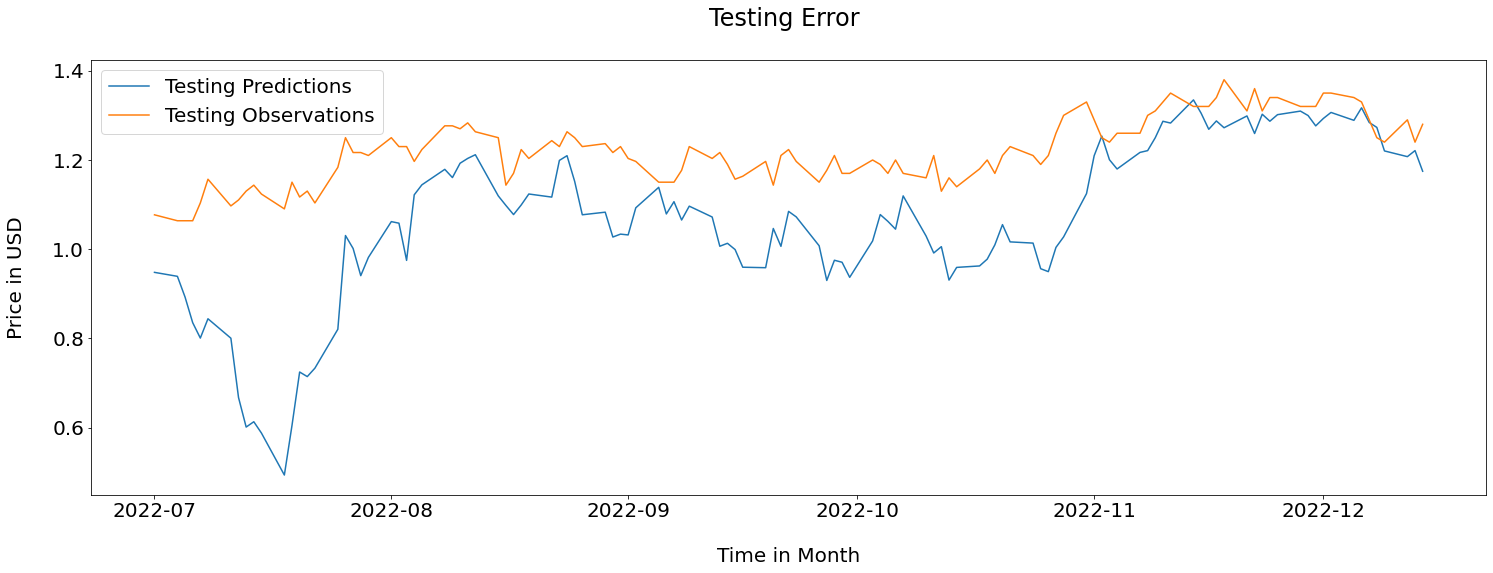

In [439]:
test_predictions = model.predict(x_test)

test_predictions=scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test)

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Testing Error \n")
plt.ylabel("Price in USD\n")
# plt.ylim(0.5,1.5)
plt.xlabel("\nTime in Month")

plt.legend(['Testing Predictions', 'Testing Observations']);

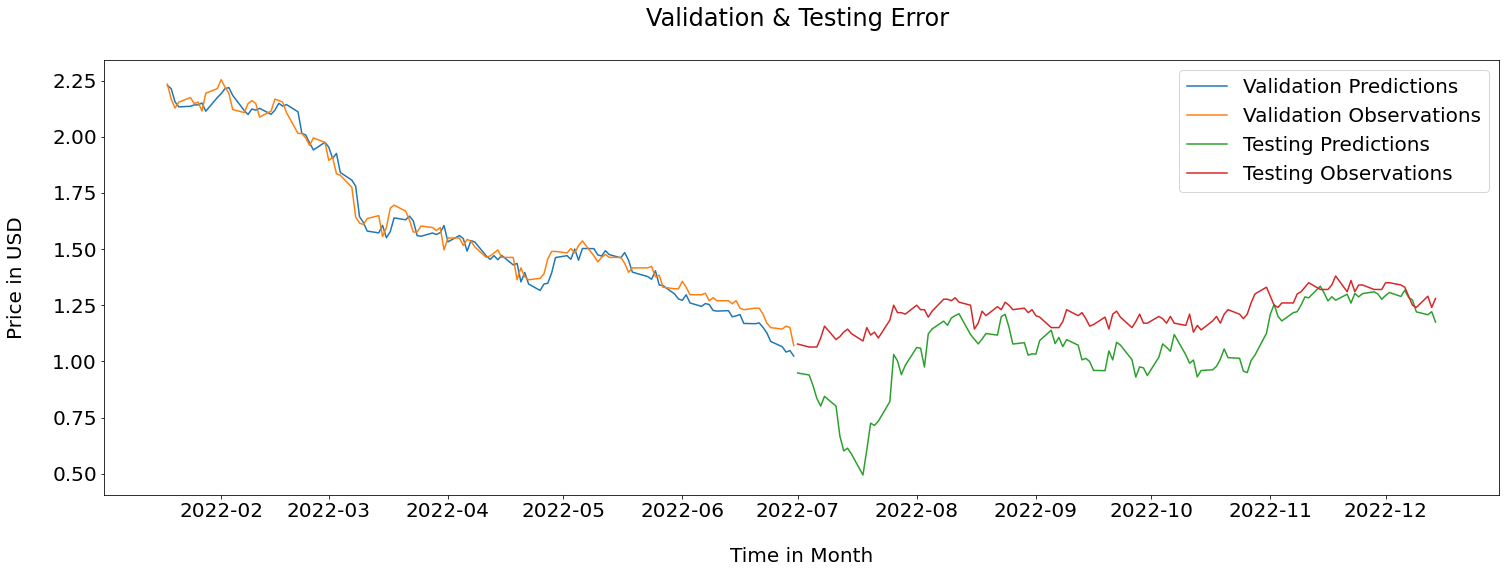

In [440]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation & Testing Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations']);

In [441]:
dates_recursive = pd.date_range(start=pd.Timestamp('2022-12-14 00:00:00'),end=pd.Timestamp('2023-01-01 00:00:00'),freq='B');

In [442]:
len(dates_recursive)

13

In [443]:
y_recursive = recursive_prediction(model,y,PAST_N_DAYS,dates_recursive)

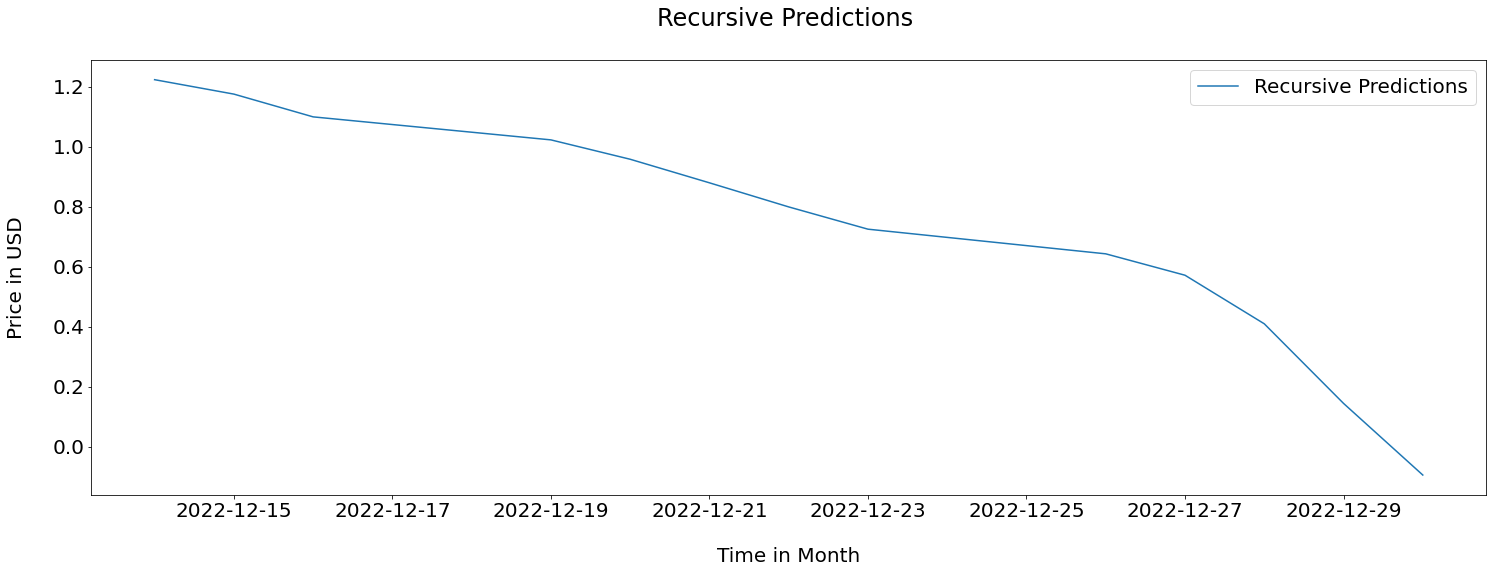

In [444]:
plt.plot(dates_recursive,y_recursive)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Recursive Predictions \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Recursive Predictions']);

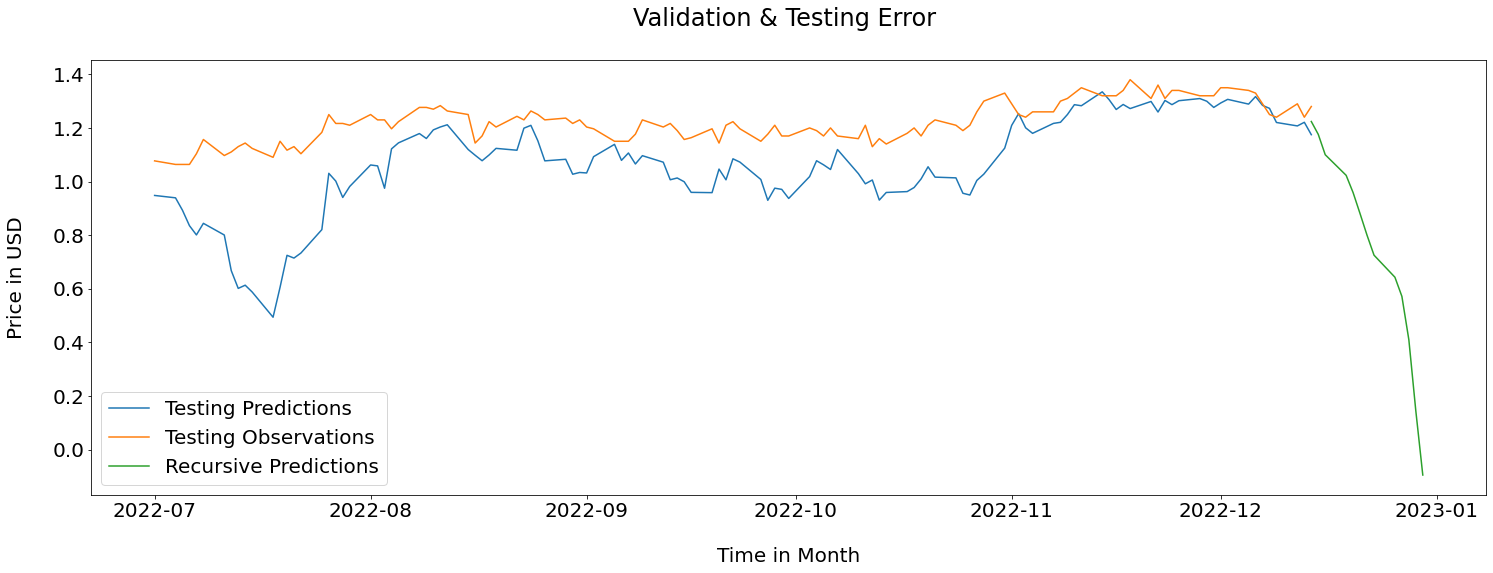

In [445]:
# plt.plot(dates_train, train_predictions)
# plt.plot(dates_train, y_train)
# plt.plot(dates_val, val_predictions)
# plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.plot(dates_recursive,y_recursive)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("Validation & Testing Error \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Month")
plt.legend(['Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);

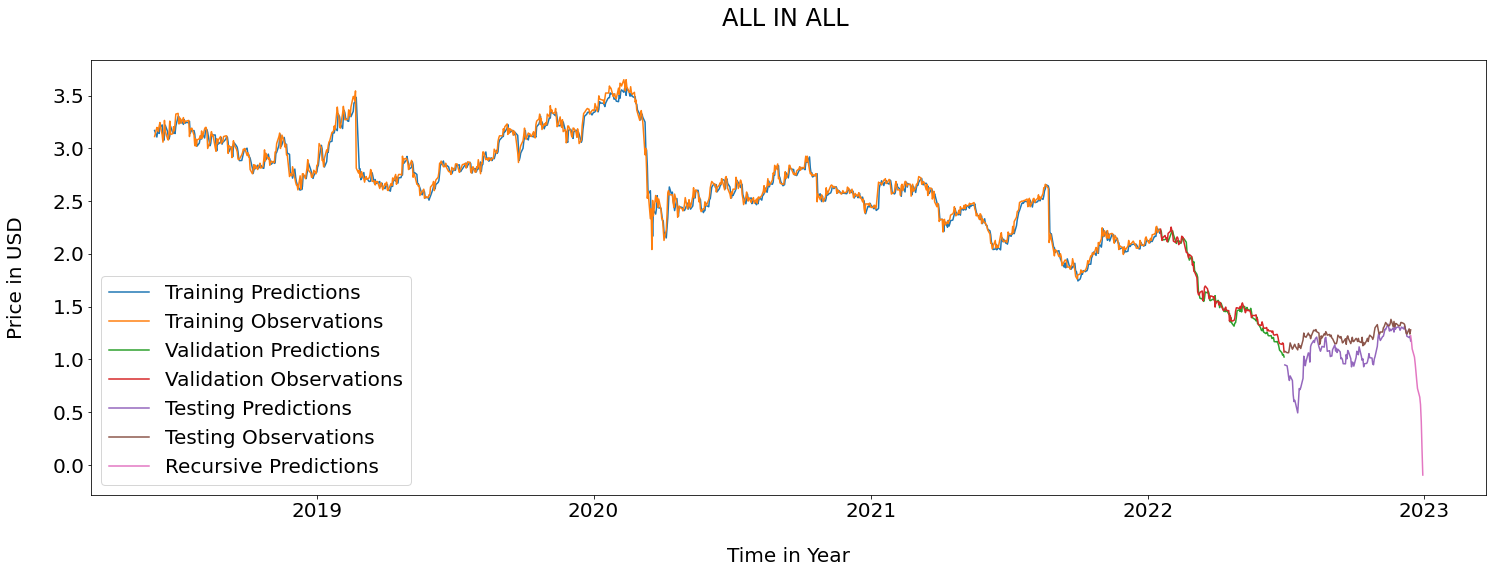

In [446]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)

plt.plot(dates_recursive,y_recursive)
plt.rcParams["figure.figsize"] = (25,8)
plt.title("ALL IN ALL \n")
plt.ylabel("Price in USD\n")
plt.xlabel("\nTime in Year")
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations',
            'Recursive Predictions']);